## EE512 – Applied Biomedical Signal Processing
# Practical session – Linear Models I
### Instructions
* This notebook provides all the questions of the practical session and the space to answer them. We recommend working directly here and then exporting the document as your report.
* Include any code used when addressing the questions, together with your answers.
* Please submit your report as a single PDF file.
* We recommend working in a group of 3–5 students; you must prepare one single report for the group (`name1_name2_name3_name4_name5_lab_LinearModelsI.pdf`), but every member needs to upload the same file individually.

In [1]:
%matplotlib widget

# Imports
import os
import json
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.regression.linear_model import yule_walker



from scipy.signal import lfilter

# File paths
fbci = os.path.join(os.getcwd(), 'data', 'bci.json')
fafs = os.path.join(os.getcwd(), 'data', 'AF_sync.dat')
fspc = os.path.join(os.getcwd(), 'data', 'speech.dat')
fbld = os.path.join(os.getcwd(), 'data', 'blood.dat')

### Experiment 1: classifying EEG signals
The file `/data/bci.mat` contains two data matrices, `left_hand` and `right_foot`, from a brain-computer interface (BCI) experiment. Each column in these matrices corresponds to a 2-second electroencephalography (EEG) recording (sampling frequency of 128 Hz) from the same electrode. The recordings in `left_hand` (respectively `right_foot`) were performed while the subject imagines a movement of the left hand (resp. right foot). The goal of the BCI experiment is to be able to “guess” what is being imagined based on the EEG signals alone.

We start by importing the signals (and removing their averages to better approximate our AR models):

In [3]:
with open(fbci, 'r') as f:
    jc = json.load(f)

eeg_lh = np.array(jc['left_hand'])
eeg_rf = np.array(jc['right_foot'])

eeg_lh -= np.mean(eeg_lh, axis=0, keepdims=True)
eeg_rf -= np.mean(eeg_rf, axis=0, keepdims=True)

eeg_lh.shape

(256, 4)

#### AR model order
A useful first step to look for structure in the signals is estimating the AR model order of each signal. We define a function `ar_order` to fit models of different orders, obtain the model noise variance, and apply a specific criterion:

In [6]:
def ar_order(x, omax, Aff=0):
    """
    AR order estimation
    x: signal
    omax: maximum possible order
    Aff: 0 no graphic display; 1 display
    
    Returns:
    omdl: order estimated with MDL
    """
    
    nx = len(x)
    s = np.zeros((omax,))
    c = np.zeros((omax,))

    for k in range(omax):
        
        n = k+1
        
        ar_model = AutoReg(x, n, trend='n')
        ar_model_fit = ar_model.fit()
        sg2 = ar_model_fit.sigma2
        
        s[k] = sg2
        c[k] = nx * np.log(sg2) + (n+1) * np.log(nx)

    if Aff == 1:
        plt.figure()
        plt.plot(range(1, omax+1), mdl, 'o-')
        plt.title('Criterion')
        plt.show()
        
    return np.argmin(c)+1, s, c

**Question 1.1.** What is the name of the criterion being applied in the function `ar_order` implemented above? How would you change the code to apply the Akaike Information Criterion (AIC) instead?

MDL

In [10]:
#c[k] = nx * np.log(sg2) + (n+1)*2

Let's look at the order estimate for an example signal, in a reasonable range up to 20:

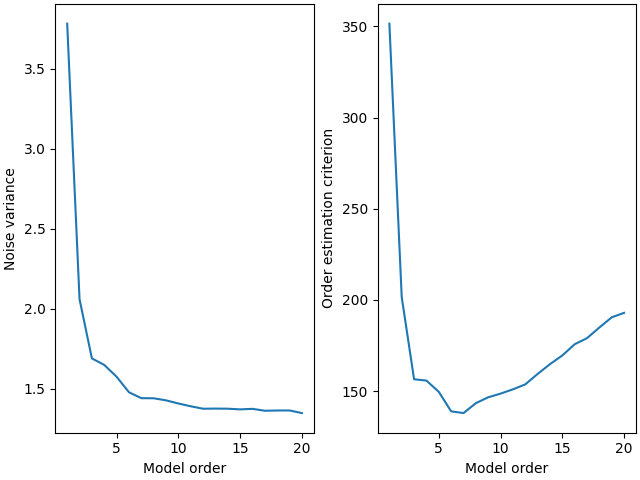

In [13]:
nmax = 20
_, s, c = ar_order(eeg_lh[:,1], nmax)

fig = plt.figure(constrained_layout=True)
n = np.arange(1, nmax+1)
plt.subplot(1,2,1)
plt.plot(n, s)
plt.xlabel('Model order')
plt.ylabel('Noise variance')
plt.subplot(1,2,2)
plt.plot(n, c)
plt.xlabel('Model order')
plt.ylabel('Order estimation criterion')
plt.show()

**Question 1.2.** Do the two curves obtained for this example signal behave as we would expect? What are their most important characteristics?

**Answer 1.2.** 

we can see that the vartiance deacreases with the other as expected but the it is not the case fot eh the order estimation. indeed the oder estimation starts to increase after ~6 -> overfitting

We can now estimate and print the optimal model order for every signal of each condition:

In [18]:
nmax = 10

print("\nLeft hand :", end="")
for k in range(eeg_lh.shape[1]):
    n, _, _ = ar_order(eeg_lh[:,k], nmax)
    print("  {:02.0f}".format(n), end="")
print("")

print("Right foot:", end="")
for k in range(eeg_rf.shape[1]):
    n, _, _ = ar_order(eeg_rf[:,k], nmax)
    print("  {:02.0f}".format(n), end="")
print("\n")


Left hand :  07  07  03  09
Right foot:  04  04  04  03



**Question 1.3.** Based on these AR order estimates, is there already a predominant difference between the two categories overall? And if we wish to perform AR model estimation using a common choice of model order for all signals, which value should be chosen, and why?

**Answer 1.3.** 

we can see that th emodel is more appropriate from the right foot recording that the lh since the cretiterion gives us orders closer to each other

#### Movement prediction
We now look at the resulting AR coefficients when choosing a model order of `3`:

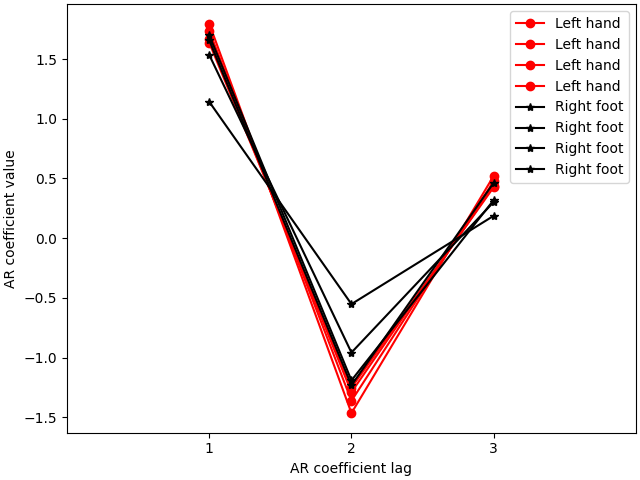

In [23]:
n = 3
fig = plt.figure(constrained_layout=True)

for k in range(eeg_lh.shape[1]):
    ar_model = AutoReg(eeg_lh[:,k], n, trend='n')
    ar_model_fit = ar_model.fit()
    plt.plot(range(1,n+1), ar_model_fit.params, 'ro-', label='Left hand')
    
for k in range(eeg_rf.shape[1]):
    ar_model = AutoReg(eeg_rf[:,k], n, trend='n')
    ar_model_fit = ar_model.fit()
    plt.plot(range(1,n+1), ar_model_fit.params, 'k*-', label='Right foot')
    
plt.legend()
plt.xticks(ticks=(1,2,3))
plt.xlabel('AR coefficient lag')
plt.ylabel('AR coefficient value')
plt.xlim(0,n+1)

plt.show()


**Question 1.4.** On which coefficients is the separation between categories most promising?

**Answer 1.4.**  

-> the a2 seems to have more seperation between the categories meaning that we will be able differetntiate between them in further analysis

### Experiment 2: AR model evolution over time
Real-life physiological signals can often vary substantially (and meaningfully) throughout a recording. It’s usually good practice to have a look at the data before trying to apply models. Consider the signal in `AF_sync.dat` – a recording of ECG atrial activity during atrial fibrillation (sampling frequency of 50 Hz). We start by importing the signal:

In [28]:
with open(fafs, 'r') as f:
    txt = f.readlines()
    af_sync = np.array([float(s[:-1]) for s in txt])
    
af_sync -= np.mean(af_sync)

#### Changes across time
Let's plot the signal and consider its evolution over the course of the recording. At the start (until sample ~2000 approximately), the signal is moderately organized; then it becomes very organized until sample ~3000. This probably corresponds to a drastic reduction in the number of fibrillatory waves in the atrial tissue (flutter). In the last part of the recording, the fibrillation, and thus the signal, becomes very disorganized.

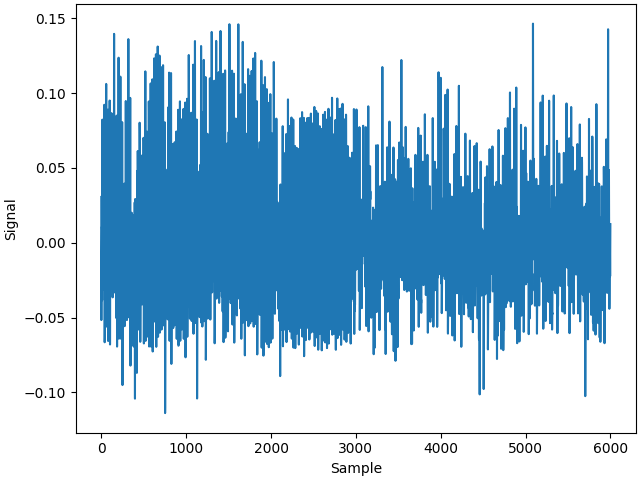

In [31]:
fig = plt.figure(constrained_layout=True)
ax = plt.axes()
plt.plot(af_sync)
plt.xlabel('Sample')
plt.ylabel('Signal')
plt.show()

**Question 2.1.** The code below is intended to plot the signal again and mark the three periods described above, but it is not yet complete. Make the necessary modifications to show all three periods of interest.

**Answer 2.1.**

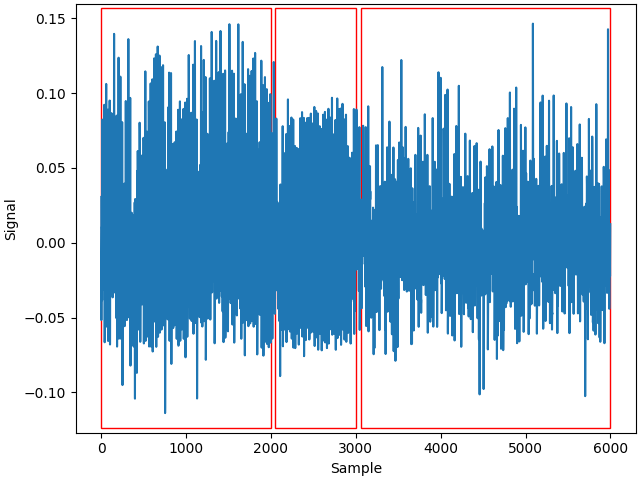

In [35]:
fig = plt.figure(constrained_layout=True)
ax = plt.axes()
plt.plot(af_sync)
plt.xlabel('Sample')
plt.ylabel('Signal')

segments = [[0, 2000], [2050, 3000], [3060, 6000]]
eclr = [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 0.0]]

ax.axvspan(segments[0][0], segments[0][1], ymin=0.01, ymax=0.99, ec=eclr[0], fill=False)
ax.axvspan(segments[1][0], segments[1][1], ymin=0.01, ymax=0.99, ec=eclr[0], fill=False)
ax.axvspan(segments[2][0], segments[2][1], ymin=0.01, ymax=0.99, ec=eclr[0], fill=False)
plt.show()

#### Adaptive modeling
The clearly different states in `af_sync`, which vary across time, can be studied and modeled more quantitatively using a sliding-window approach. We thereby consider a segmentation of the signal into 500-sample windows with 50% overlap. For each segment, we can then estimate (i) the signal variance, (ii) optimal AR order, and (iii) the AR coefficients & excitation variance, as follows:

In [38]:
nw = 500
nv = round(nw*0.50)
nt = len(af_sync)

kt = []
ki, kf = 0, nw

# Getting the border and middle indices for each segment
while True:
    kt.append([ki, round(0.5*(ki+kf)), kf])
    ki += nw - nv
    kf += nw - nv
    if kf > nt: break

nc = len(kt)
arv = np.zeros((nc,))
aro = np.zeros((nc,), dtype=int)
arr = np.zeros((nc,))
nmax = 40

# Modeling the signal for each segment
for kc in range(nc):
    
    ys = af_sync[kt[kc][0]:kt[kc][2]]

    arv[kc] = np.var(ys)
    aro[kc], _, _ = ar_order(ys, nmax)
    
    _, sigma = yule_walker(ys, order=int(aro[kc]), method="mle")
    arr[kc] = sigma**2 / arv[kc]

We can then plot together the time evolution of the raw signal, the signal variance, the AR order, and the ratio of excitation variance to signal variance.

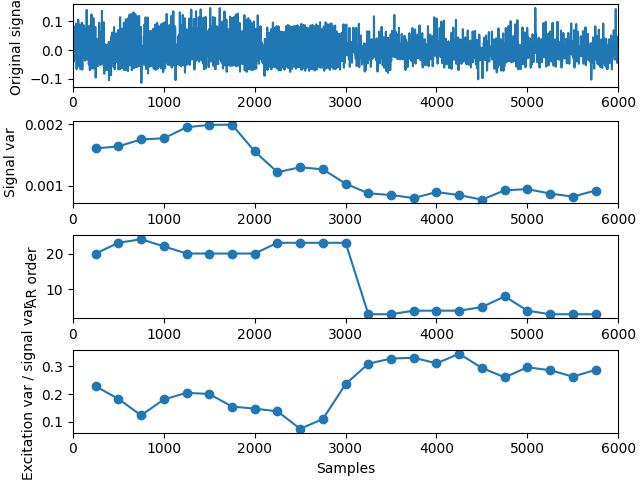

In [40]:
fig = plt.figure(constrained_layout=True)
t = np.array(kt)[:,1]

plt.subplot(4,1,1)
plt.plot(af_sync)
plt.ylabel('Original signal')
plt.xlim(0, len(af_sync))

plt.subplot(4,1,2)
plt.plot(t, arv, 'o-')
plt.ylabel('Signal var')
plt.xlim(0, len(af_sync))

plt.subplot(4,1,3)
plt.plot(t, aro, 'o-')
plt.ylabel('AR order')
plt.xlim(0, len(af_sync))

plt.subplot(4,1,4)
plt.plot(t, arr, 'o-')
plt.ylabel('Excitation var / signal var')
plt.xlim(0, len(af_sync))
plt.xlabel('Samples')

plt.show()

**Question 2.2.** Interpret the time evolution of the parameters plotted above, and how they relate to the organization of the signal in the three afore-mentioned stages.

**Answer 2.2.**
The better a signal is organized, the higher the AR order is. In our case, we can see that the highest AR order is approximately at 3000 samples which correspond to the fully organized signal. Another point to see is that excitation variance corresponds to a little proportion of the signal variance, which makes sense as the excitation is much smaller in an organized signal. After the most organized part of the signal, we have a desorganized signal, which is seen with the big drop of the AR order and the rapid rise up of the proportion of the excitation variance compared to the signal variance.


#### Signal stability and organization
Finally, another way of evaluating how organized a signal is, is by looking at its equivalent filter transfer function *H(z)* and the positioning of the corresponding poles. We can focus specifically on the three states defined previously in `segments`, as follows:

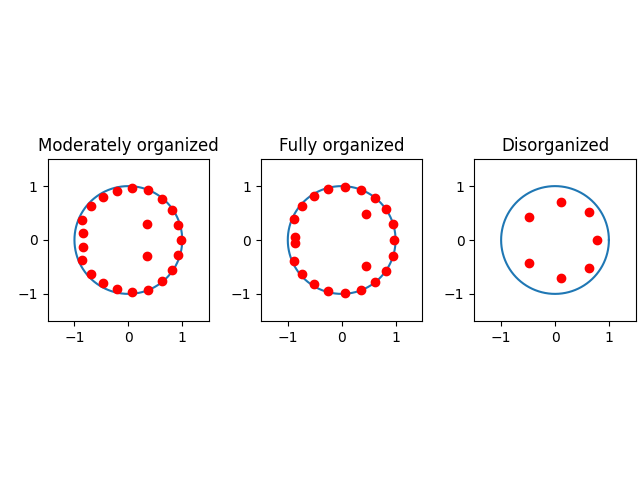

In [44]:
roots = []

for seg in segments:
    
    ys = af_sync[seg[0]:seg[1]]
    
    aro, _, _ = ar_order(ys, nmax)
    rho, _ = yule_walker(ys, order=int(aro), method="mle")
    
    rho = np.concatenate((-rho[::-1], np.array([1])), axis=0)
    roots.append(1 / np.roots(rho))

fig = plt.figure(constrained_layout=True)
t = np.linspace(0, 2*np.pi, 1000)
titles = ['Moderately organized', 'Fully organized', 'Disorganized']

for k in range(3):
    plt.subplot(1,3,k+1)
    plt.plot(np.cos(t), np.sin(t))
    plt.plot(np.real(roots[k]), np.imag(roots[k]), 'ro')
    plt.axis('square')
    plt.xlim([-1.5, 1.5])
    plt.ylim([-1.5, 1.5])
    plt.title(titles[k])

plt.show()

And the proximity to the unit circle can be further summarized in terms of the average magnitude:

In [48]:
for kr in range(len(roots)):
    print(titles[kr] + ': {:.3f}'.format(np.mean(np.abs(roots[kr]))))

Moderately organized: 0.906
Fully organized: 0.945
Disorganized: 0.732


**Question 2.3.** Comment on how signal organization relates to pole location (proximity to the circle).

**Answer 2.3.** 
The organization of the signal can be assessed by their proximity with the unit circle (so the closest all the points are from the unit circle, the more organized the signal is). Another point that differentiate the moderately and fully organized is the symetry: the poles of the fully organized signal are perfectly symetric. The last point to assess is that the more organized the signal is, the more close to 1 the average magnitude is. In our case, the fully organized signal is the closest to 1.

### Experiment 3: recovering the excitation (whitening filter)
The signal in `speech.dat` corresponds to the spoken sound */a/*, sampled at 8 kHz. Used in language, we expect this signal to be clearly structured. We start by importing and plotting it:

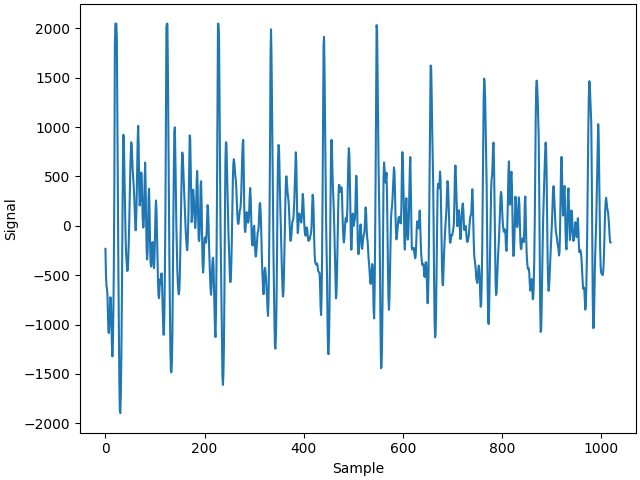

In [54]:
with open(fspc, 'r') as f:
    txt = f.readlines()
    speech = np.array([float(s[:-1]) for s in txt])

speech -= np.mean(speech)

fig = plt.figure(constrained_layout=True)
ax = plt.axes()
plt.plot(speech)
plt.xlabel('Sample')
plt.ylabel('Signal')
plt.show()

Using the functions `ar_order` and `yule_walker` introduced before, we can estimate the optimal model order for this signal, and then the corresponsing model parameters:

In [57]:
aro1, _, _ = ar_order(speech, 40)
rho1, sgm1 = yule_walker(speech, order=int(aro1), method="mle")

#### The underlying excitation signal
In the framework of AR modeling, the excitation signal driving the observed speech signal can be estimated using a filtering step as follows:

In [60]:
exc1 = lfilter(np.concatenate(([1], -rho1), axis=0), [1], speech)

**Question 3.1.** Explain why the excitation can be estimated in this way.

**Answer 3.1.** `Write your answer here`

We can now visualize the estimated excitation signal:

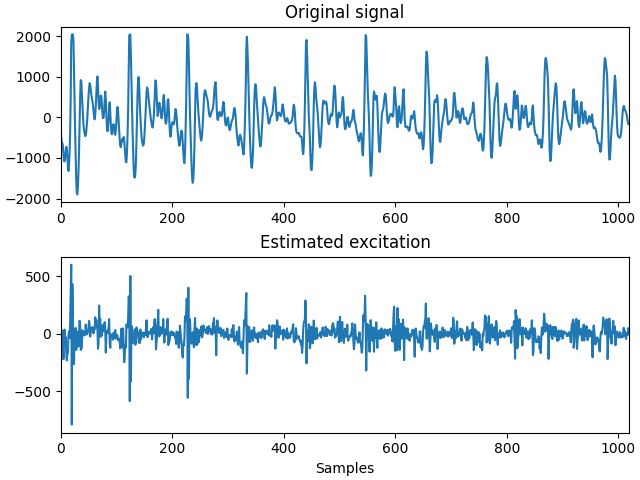

In [65]:
fig = plt.figure(constrained_layout=True)
plt.subplot(2,1,1)
plt.plot(speech)
plt.title('Original signal')
plt.xlim(0, len(speech))

plt.subplot(2,1,2)
plt.plot(exc1)
plt.title('Estimated excitation')
plt.xlim(0, len(speech))
plt.xlabel('Samples')
plt.show()

**Question 3.2.** Compare the excitation with the speech signal. Does the excitation look like white noise?

**Answer 3.2.**

yes, it looks like white noise, since the shape of the singla in indeed kept , but there is much osciallations oround the signal. so we have high friquencies as well low ones

We can test more objectively whether the excitation is indeed similar to white noise by looking at its normalized autocorrelation, as follows:

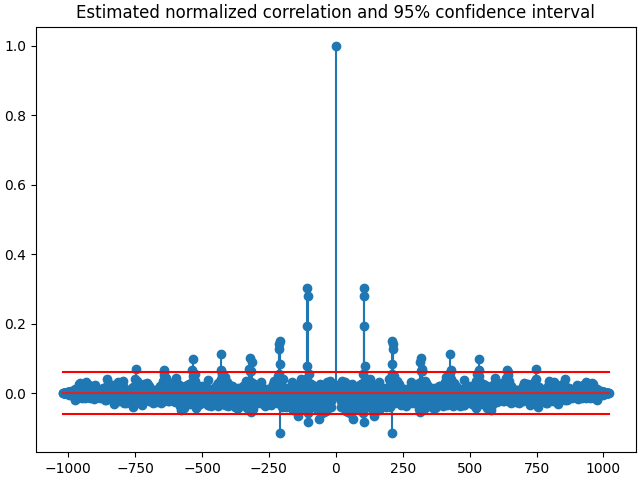

Proportion above 5% threshold: 0.023553


In [70]:
def test_white(x, Aff=0):
    """
    Computation of the ratio of normalized autocorrelation estimates 
    larger than a 5% threshold
    x: signal
    Aff: 0 no graphic display; 1 display
    """
    
    K = len(x)
    
    # Calculate the biased autocorrelation of the signal
    v = np.correlate(x, x, mode='full') / K
    # Note: K-1 is the index for zero lag
    
    thresh = 1.96 / np.sqrt(K)
    pc = np.sum(np.abs(v[K:] / v[K-1]) > thresh) / (K-1)
    
    if Aff == 1:
        fig = plt.figure(constrained_layout=True)
        ml = K-1
        lags = range(-ml, ml + 1)
        corr = v[K-1 - ml : K-1 + ml + 1] / v[K-1]
        plt.stem(lags, corr)
        plt.plot([-ml, ml], [+thresh, +thresh], 'r')
        plt.plot([-ml, ml], [-thresh, -thresh], 'r')
        plt.title('Estimated normalized correlation and 95% confidence interval')
        plt.show()

    return pc

print("Proportion above 5% threshold: {:f}".format(test_white(exc1, Aff=1)))

**Question 3.3.** What can we say based on this result?

**Answer 3.3.** 

we cant see that this correratiion have signal seem to be highly unstructured since when |k| > 0 we only find low amplidute values with a quite flatt line (smmal variation of amplitude)

We now consider a different example: a timeseries of daily blood systolic pressure recorded from a patient, stored in `blood.dat`:

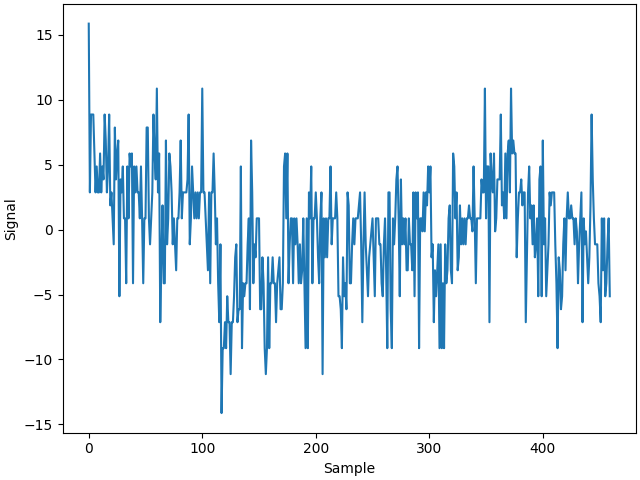

In [75]:
with open(fbld, 'r') as f:
    txt = f.readlines()
    txt = [s[:-1].split() for s in txt]
    blood = np.array([float(s[0]) for s in txt])

blood -= np.mean(blood)

fig = plt.figure(constrained_layout=True)
ax = plt.axes()
plt.plot(blood)
plt.xlabel('Sample')
plt.ylabel('Signal')
plt.show()

**Question 3.4.** Repeat the full analysis done for the speech signal (i.e. estimating AR order, model parameters, excitation signal, whiteness test). How does this excitation signal compare to that of the speech example?

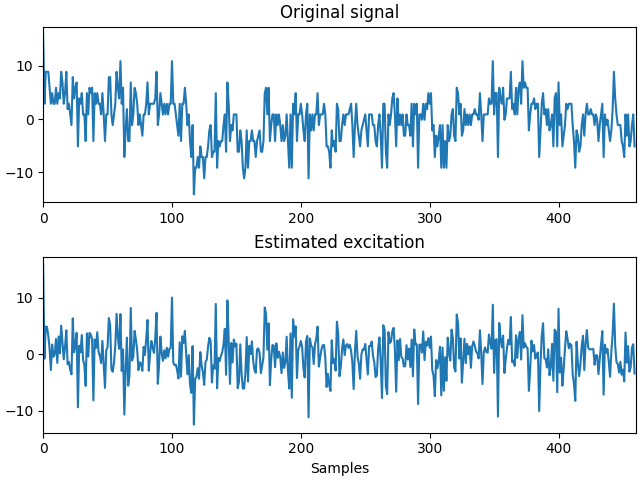

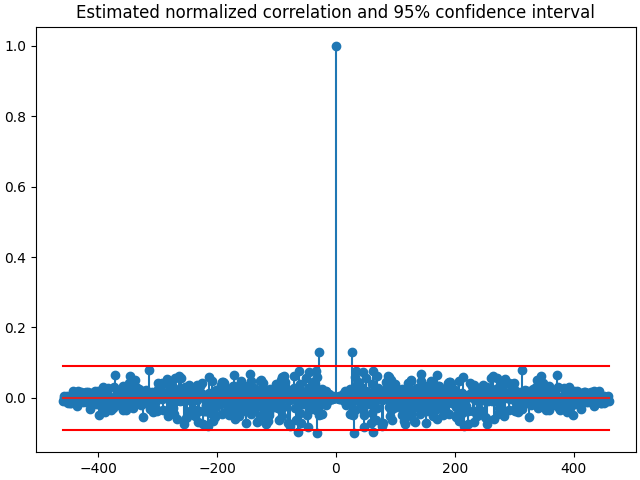

Proportion above 5% threshold: 0.006536


In [78]:
aro2, _, _ = ar_order(blood, 40)
rho2, sgm2 = yule_walker(blood, order=int(aro1), method="mle")
exc2 = lfilter(np.concatenate(([1], -rho2), axis=0), [1], blood)

fig = plt.figure(constrained_layout=True)
plt.subplot(2,1,1)
plt.plot(blood)
plt.title('Original signal')
plt.xlim(0, len(blood))

plt.subplot(2,1,2)
plt.plot(exc2)
plt.title('Estimated excitation')
plt.xlim(0, len(blood))
plt.xlabel('Samples')
plt.show()

print("Proportion above 5% threshold: {:f}".format(test_white(exc2, Aff=1)))

**Answer 3.4.** `Write your answer here`

The signal is less structured than the speech one (it whiteness is better). We see that its normalized correlation is even more flatter. Even if we compare the original signals, we can that systolic pressure has almost no structure.

### Have a good session, and don't hesitate to ask questions!